### Download all Wikipedia entry's about the Gemeinden in Switzerland

In [19]:
import requests
from bs4 import BeautifulSoup
import time
import csv
import wikipediaapi
import os

# Anzahl Gemeinden zum Testen (z. B. 10). Später: LIMIT = None für alle
LIMIT = None
CSV_FILE = "01_Training/wiki_gemeinden_ch.csv"

# Wikipedia-API initialisieren mit User-Agent
wiki = wikipediaapi.Wikipedia(
    language='de',
    user_agent='GemeindeScraper/1.0 (kontakt@example.com)'
)

# Wikipedia-Seite mit Gemeinden der Schweiz
url = "https://de.wikipedia.org/wiki/Liste_Schweizer_Gemeinden"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

# Tabellen mit Gemeinden extrahieren
tables = soup.find_all("table", {"class": "wikitable"})

# Gemeindenamen sammeln
cities = []
for table in tables:
    rows = table.find_all("tr")[1:]
    for row in rows:
        cells = row.find_all("td")
        if cells and cells[0].find("a"):
            city_name = cells[0].find("a").get_text(strip=True)
            cities.append(city_name)

# Optional limitieren
if LIMIT is not None:
    cities = cities[:LIMIT]

print(f"{len(cities)} Gemeinden ausgewählt für Download.")

# Vorhandene Einträge laden (wenn vorhanden)
already_downloaded = set()
if os.path.exists(CSV_FILE):
    with open(CSV_FILE, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        next(reader)  # Überspringe Header
        for row in reader:
            if row:
                already_downloaded.add(row[0])

# Datei im Anhang-Modus öffnen
with open(CSV_FILE, "a", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)

    # Wenn Datei leer ist, Header schreiben
    if os.stat(CSV_FILE).st_size == 0:
        writer.writerow(["Gemeinde", "Wikipedia_Text"])

    for i, city in enumerate(cities):
        if city in already_downloaded:
            print(f"[{i+1}/{len(cities)}] {city} wurde bereits heruntergeladen – übersprungen")
            continue

        page = wiki.page(city)
        if page.exists():
            print(f"[{i+1}/{len(cities)}] {city} gefunden")
            text = page.text
        else:
            print(f"[{i+1}/{len(cities)}] {city} nicht gefunden")
            text = ""

        writer.writerow([city, text])
        f.flush()  # sofort speichern
        time.sleep(1)


2115 Gemeinden ausgewählt für Download.
[1/2115] Aadorf wurde bereits heruntergeladen – übersprungen
[2/2115] Aarau wurde bereits heruntergeladen – übersprungen
[3/2115] Aarberg wurde bereits heruntergeladen – übersprungen
[4/2115] Aarburg wurde bereits heruntergeladen – übersprungen
[5/2115] Aarwangen wurde bereits heruntergeladen – übersprungen
[6/2115] Abtwil wurde bereits heruntergeladen – übersprungen
[7/2115] Aclens wurde bereits heruntergeladen – übersprungen
[8/2115] Acquarossa wurde bereits heruntergeladen – übersprungen
[9/2115] Adelboden wurde bereits heruntergeladen – übersprungen
[10/2115] Adligenswil wurde bereits heruntergeladen – übersprungen
[11/2115] Adliswil wurde bereits heruntergeladen – übersprungen
[12/2115] Aedermannsdorf wurde bereits heruntergeladen – übersprungen
[13/2115] Aefligen wurde bereits heruntergeladen – übersprungen
[14/2115] Aegerten wurde bereits heruntergeladen – übersprungen
[15/2115] Aesch (BL) wurde bereits heruntergeladen – übersprungen
[16/2

## Start of define training dataset

In [1]:
# All the necessary imports
from deep_translator import GoogleTranslator
from tqdm import tqdm
import pandas as pd
from datetime import datetime, timedelta
import json
import pandas as pd
import json
import re
import spacy
from tqdm.notebook import tqdm
from spacy.matcher import PhraseMatcher
from spacy.util import filter_spans

Download the list of all Gemeinden:

https://www.agvchapp.bfs.admin.ch/de

use the REST-API:

https://www.agvchapp.bfs.admin.ch/api/communes/snapshot?date=01-01-2015


In [2]:
# Calculate the date (yesterday)
date = (datetime.now() - timedelta(days=1)).strftime('%d-%m-%Y')
url = f"https://www.agvchapp.bfs.admin.ch/api/communes/snapshot?date={date}"

# Read CSV directly from the URL
df = pd.read_csv(url)

# Save to CSV file
filename = f"03_Label/Amtliches_Gemeindeverzeichnis_Schweiz.csv"
df.to_csv(filename, index=False, encoding='utf-8')

print(f"""Saved "Amtliches_Gemeindeverzeichnis_Schweiz.csv" with {len(df)} rows.""")


Saved "Amtliches_Gemeindeverzeichnis_Schweiz.csv" with 2284 rows.


Load and save function for the preparation of the label file

In [3]:
def load_labels_from_json(path):
    """Loads a list of labels from a JSON file."""
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def save_labels_to_json(labels, path):
    """Saves a list of labels to a JSON file."""
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(labels, f, ensure_ascii=False, indent=2)

def append_labels_to_json(new_labels, path, deduplicate=True, sort=False):
    """Appends new labels to an existing JSON list at 'path'."""

    # Load existing labels
    try:
        with open(path, 'r', encoding='utf-8') as f:
            existing_labels = json.load(f)
    except FileNotFoundError:
        existing_labels = []

    # Combine existing + new
    combined = existing_labels + new_labels

    # Remove duplicates (optional)
    if deduplicate:
        combined = list(set(combined))

    # Sort (optional)
    if sort:
        combined = sorted(combined)

    # Save back to JSON
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(combined, f, ensure_ascii=False, indent=2)

    print(f"✅ Appended {len(new_labels)} items to {path} (total now: {len(combined)})")



In [4]:
input_path_label_json = "03_Label/gemeinden_labels_v2.json"
output_path_label_json = input_path_label_json
list_gemeinden_csv = "03_Label/Amtliches_Gemeindeverzeichnis_Schweiz.csv"

Load all `Name`and `ShortName`

In [5]:
# --- Load CSV ---
df = pd.read_csv(list_gemeinden_csv)

# Optional: show columns
print(df.columns)

# Filter and clean relevant columns
df = df[['Name', 'ShortName']].dropna()

# Create label list
labels = []
for _, row in df.iterrows():
    labels.append(row['Name'])
    labels.append(row['ShortName'])

save_labels_to_json(labels, output_path_label_json)

print(f"✅ Saved {len(labels)} entries to {output_path_label_json}")

Index(['HistoricalCode', 'BfsCode', 'ValidFrom', 'ValidTo', 'Level', 'Parent',
       'Name', 'ShortName', 'Inscription', 'Radiation', 'Rec_Type_fr',
       'Rec_Type_de'],
      dtype='object')
✅ Saved 4568 entries to 03_Label/gemeinden_labels_v2.json


If the names are in multiple langauges, they are split with `/`. Create for name a label

In [6]:
labels = load_labels_from_json(input_path_label_json)
expanded_labels = []
for label in labels:
    if '/' in label:
        parts = label.split('/')
        expanded_labels.extend(part.strip() for part in parts)
    else:
        expanded_labels.append(label.strip())

# Optional: remove duplicates and sort
expanded_labels = sorted(set(expanded_labels))

save_labels_to_json(expanded_labels, output_path_label_json)

Load the canton name (`Level = 1`). If the names are in multiple langauges, they are split with `/`. Create for name a label. Add a version for the prefix Kanton (DE), Canton (FR) and Cantone (IT)
And create a version with the the abbreviation for Canton in front of the Name (`Kt.` and `Ct.`)into the label

In [9]:
# --- Load CSV ---
df = pd.read_csv(list_gemeinden_csv)

# --- Filter rows where Level == 1 ---
df_level1 = df[df['Level'] == 1]

# --- Extract and expand 'Name' values ---
expanded_names = []
for name in df_level1['Name'].dropna():
    if '/' in name:
        parts = name.split('/')
        names = [part.strip() for part in parts]
    else:
        names = [name.strip()]

    # For each name, create 3 versions: plain, Kt., and Ct.
    for n in names:
        expanded_names.append(n)
        expanded_names.append(f"Kt. {n}")
        expanded_names.append(f"Ct. {n}")
        expanded_names.append(f"Kanton {n}")
        expanded_names.append(f"Kantons {n}")
        expanded_names.append(f"Canton {n}")
        expanded_names.append(f"Cantone {n}")

# --- Optional: remove duplicates and sort ---
expanded_names = sorted(set(expanded_names))

# --- Save to JSON ---
output_path_label_json = "01_Training/gemeinden_labels.json"
append_labels_to_json(expanded_names, output_path_label_json, deduplicate=True, sort=False)


✅ Appended 217 items to 01_Training/gemeinden_labels.json (total now: 2567)


Add the abbreviation for the canton with an without brackets.

In [10]:
# --- Load CSV ---
df = pd.read_csv(list_gemeinden_csv)

# --- Filter rows where Level == 1 ---
df_level1 = df[df['Level'] == 1]

# --- Extract ShortNames and add bracketed versions ---
expanded_shortnames = []
for short in df_level1['ShortName'].dropna():
    short = short.strip()
    expanded_shortnames.append(short)
    expanded_shortnames.append(f"({short})")

# --- Optional: remove duplicates and sort ---
expanded_shortnames = sorted(set(expanded_shortnames))

# --- Append to existing JSON file ---
append_labels_to_json(expanded_shortnames, output_path_label_json, deduplicate=True, sort=False)

✅ Appended 52 items to 01_Training/gemeinden_labels.json (total now: 2593)


Add the prefixes `Stadt` , `Ville de` and `Città di` in front of the `ShortName`


In [11]:
# --- Load CSV ---
df = pd.read_csv(list_gemeinden_csv)

# --- Extract ShortNames and add "Stadt" versions ---
expanded_shortnames = []
for short in df['ShortName'].dropna():
    short = short.strip()
    expanded_shortnames.append(short)
    expanded_shortnames.append(f"Stadt {short}")
    expanded_shortnames.append(f"Ville de {short}")
    expanded_shortnames.append(f"Città di {short}")
    expanded_shortnames.append(f"{short}s")

# --- Optional: remove duplicates and sort ---
expanded_shortnames = sorted(set(expanded_shortnames))

# --- Append to existing JSON file ---
append_labels_to_json(expanded_shortnames, output_path_label_json, deduplicate=True, sort=False)


✅ Appended 11080 items to 01_Training/gemeinden_labels.json (total now: 11471)


Delete all the redundant labels.

In [12]:
labels = load_labels_from_json(input_path_label_json)
# --- Remove duplicates and sort (optional) ---
unique_labels = sorted(set(labels))  # or just list(set(labels)) if order doesn't matter
print(f"✅ Found {len(unique_labels)} unique labels")
# --- Save cleaned JSON ---
save_labels_to_json(unique_labels, output_path_label_json)

✅ Found 11471 unique labels


What is missing inside the training labels:
  - Gemeinden
  - Länder

### Create a solution for the ambiguous words

In [ ]:
# --- Load shortnames from your CSV ---
df = pd.read_csv(list_gemeinden_csv)
shortnames = sorted(set(name.strip() for name in df['ShortName'].dropna()))

# --- Translator ---
translator = GoogleTranslator(source='auto', target='en')

results = []
ambiguous = []

# --- Translate with progress bar ---
for name in tqdm(shortnames, desc="Translating"):
    try:
        translated = translator.translate(name)
    except Exception as e:
        translated = f"ERROR: {e}"

    is_ambiguous = name.lower() != translated.lower()

    results.append({
        "original": name,
        "translated": translated,
        "ambiguous": is_ambiguous
    })

    if is_ambiguous:
        ambiguous.append(name)

# --- Summary ---
print(f"✅ Translated {len(shortnames)} shortnames.")
print(f"⚠️ Found {len(ambiguous)} ambiguous entries.")
print("Example ambiguous:", ambiguous[:5])

# --- Save results to JSON ---
with open("01_Training/shortnames_translations.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)


Translating:   0%|          | 0/2216 [00:00<?, ?it/s]

✅ Translated 2216 shortnames.
⚠️ Found 678 ambiguous entries.
Example ambiguous: ['Aarwangen', 'Adelboden', 'Aesch (BL)', 'Aeschi (SO)', 'Affeltrangen']


In [22]:
# --- Paths ---
labels_path = "01_Training/gemeinden_labels.json"
wordlist_path = "01_Training/de_words.txt"
output_path = "01_Training/gemeinden_labels_structured.json"

# --- Load data ---
with open(labels_path, "r", encoding="utf-8") as f:
    labels = json.load(f)

with open(wordlist_path, "r", encoding="utf-8") as f:
    de_words = set(word.strip().lower() for word in f if word.strip())

# --- Process ---
structured = []
ambiguous_count = 0

for label in tqdm(labels, desc="Checking labels against dictionary"):
    is_ambiguous = label.lower() in de_words

    structured.append({
        "label": label,
        "ambiguous": is_ambiguous
    })

    if is_ambiguous:
        ambiguous_count += 1

# --- Save result ---
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(structured, f, ensure_ascii=False, indent=2)

print(f"✅ Analyzed {len(structured)} labels → {output_path}")
print(f"⚠️  Found {ambiguous_count} potentially ambiguous labels")


Checking labels against dictionary: 100%|██████████| 11471/11471 [00:00<00:00, 819611.96it/s]

✅ Analyzed 11471 labels → 01_Training/gemeinden_labels_structured.json
⚠️  Found 63 potentially ambiguous labels


In [17]:
import json
from IPython.display import display, clear_output, HTML, Javascript
import ipywidgets as widgets

# --- Load the translations ---
with open("01_Training/shortnames_translations.json", "r", encoding="utf-8") as f:
    results = json.load(f)

# --- Set up counters and storage ---
index = 0
corrected_results = [None] * len(results)  # Pre-fill with None

# --- UI Elements ---
original_label = widgets.HTML()
translated_label = widgets.HTML()
ambiguous_checkbox = widgets.Checkbox(description="Ambiguous", value=False)
save_button = widgets.Button(description="Save & Next →", button_style='success')
back_button = widgets.Button(description="← Back", button_style='info')
progress_label = widgets.HTML()

# --- Display function ---
def show_entry(i):
    entry = results[i]
    original = entry["original"]
    translated = entry["translated"]
    ambiguous = entry["ambiguous"]

    original_label.value = f"<b>Original:</b> {original}"
    translated_label.value = f"<b>Translation:</b> {translated}"
    ambiguous_checkbox.value = ambiguous
    progress_label.value = f"<i>{i + 1} / {len(results)}</i>"

# --- Save entry ---
def save_current_entry():
    entry = {
        "original": results[index]["original"],
        "translated": results[index]["translated"],
        "ambiguous": ambiguous_checkbox.value
    }
    corrected_results[index] = entry

    with open("01_Training/shortnames_translations_corrected.json", "w", encoding="utf-8") as f:
        json.dump([e for e in corrected_results if e is not None], f, ensure_ascii=False, indent=2)

# --- Button callbacks ---
def on_save_clicked(b):
    global index
    save_current_entry()
    index += 1
    if index < len(results):
        show_entry(index)
    else:
        clear_output()
        display(HTML("<h3>✅ Review complete. File saved.</h3>"))

def on_back_clicked(b):
    global index
    if index > 0:
        save_current_entry()
        index -= 1
        show_entry(index)

# --- Connect buttons ---
save_button.on_click(on_save_clicked)
back_button.on_click(on_back_clicked)

# --- Display UI ---
ui = widgets.VBox([
    original_label,
    translated_label,
    ambiguous_checkbox,
    widgets.HBox([back_button, save_button]),
    progress_label
])

display(ui)
show_entry(index)

# --- Enable keyboard shortcuts ---
display(Javascript("""
require(["base/js/keyboard"], function(keyboard) {
    document.addEventListener('keydown', function(event) {
        const buttons = document.querySelectorAll('button.widget-button');
        const ambiguousInput = document.querySelector('input[type="checkbox"]');

        if (event.key === 'Enter' || event.key === 'ArrowRight') {
            buttons[1].click();  // Save & Next
        }
        if (event.key === 'ArrowLeft') {
            buttons[0].click();  // Back
        }
        if (event.key.toLowerCase() === 'a') {
            ambiguousInput.checked = !ambiguousInput.checked;  // Toggle checkbox
            ambiguousInput.dispatchEvent(new Event('change'));
        }
    });
});
"""))



In [18]:
import json

# Load the corrected file
with open("01_Training/shortnames_translations_corrected.json", "r", encoding="utf-8") as f:
    corrected = json.load(f)

# Count ambiguous entries
ambiguous_count = sum(1 for entry in corrected if entry["ambiguous"])
total = len(corrected)

# Show result
print(f"🔍 {ambiguous_count} of {total} entries are marked as ambiguous.")


🔍 145 of 2216 entries are marked as ambiguous.


In [13]:
import json

# --- Load labels from gemeinden_labels.json ---
with open("01_Training/gemeinden_labels.json", "r", encoding="utf-8") as f:
    labels = json.load(f)

# --- Load corrected translations with ambiguity flags ---
with open("01_Training/shortnames_translations_corrected.json", "r", encoding="utf-8") as f:
    translations = json.load(f)

# --- Create a set of ambiguous originals for fast lookup ---
ambiguous_set = {entry["original"] for entry in translations if entry["ambiguous"]}

# --- Categorize each label ---
categorized_labels = []
for label in labels:
    is_ambiguous = label in ambiguous_set
    categorized_labels.append({
        "label": label,
        "ambiguous": is_ambiguous
    })

# --- Save the result ---
output_path = "01_Training/gemeinden_labels_categorized.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(categorized_labels, f, ensure_ascii=False, indent=2)

print(f"✅ Saved {len(categorized_labels)} labeled entries to {output_path}")


✅ Saved 11471 labeled entries to 01_Training/gemeinden_labels_categorized.json


### Create the training data

In [14]:
import re
import spacy
import pandas as pd
import json
from tqdm.notebook import tqdm
from spacy.matcher import PhraseMatcher
from spacy.util import filter_spans

# --- Paths & config ---
csv_path = "01_Training/wiki_gemeinden_ch.csv"
labels_path = "01_Training/gemeinden_labels.json"
categorized_labels_path = "01_Training/gemeinden_labels_categorized.json"
output_path = "01_Training/spacy_training_data_sentences.json"
limit = None  # or set a number for dev

# --- Load all labels ---
with open(labels_path, 'r', encoding='utf-8') as f:
    all_labels = json.load(f)

# --- Load categorized labels ---
with open(categorized_labels_path, 'r', encoding='utf-8') as f:
    categorized = json.load(f)

# --- Split into ambiguous and non-ambiguous sets ---
non_ambiguous_labels = sorted([entry["label"] for entry in categorized if not entry["ambiguous"]])
ambiguous_labels = {entry["label"] for entry in categorized if entry["ambiguous"]}

# --- Compile global regex for non-ambiguous labels ---
escaped_non_ambiguous = [re.escape(label) for label in non_ambiguous_labels]
regex_pattern_non_ambiguous = re.compile(r'(?<!\w)(' + '|'.join(escaped_non_ambiguous) + r')(?!\w)', re.IGNORECASE)

# --- spaCy setup ---
nlp = spacy.blank("de")
nlp.add_pipe("sentencizer")

# --- Global PhraseMatcher for non-ambiguous labels ---
global_matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
global_label_docs = [nlp.make_doc(label) for label in non_ambiguous_labels]
global_matcher.add("LOC", global_label_docs)

# --- Load CSV ---
df = pd.read_csv(csv_path)
if limit is not None:
    df = df.head(limit)
assert 'Wikipedia_Text' in df.columns and 'Gemeinde' in df.columns, "Expected columns not found."

training_data = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    text = row['Wikipedia_Text']
    gemeinde = row['Gemeinde']
    
    if pd.isna(text) or not text.strip():
        continue

    doc = nlp(text)

    for sent in doc.sents:
        sent_text = sent.text.strip()
        if not sent_text:
            continue

        sent_doc = nlp(sent_text)

        # --- Global PhraseMatcher (non-ambiguous) ---
        matched_spans = []
        for match_id, start, end in global_matcher(sent_doc):
            span = sent_doc[start:end]
            matched_spans.append((span.start_char, span.end_char, "LOC"))

        # --- Global regex for non-ambiguous labels ---
        for match in regex_pattern_non_ambiguous.finditer(sent_text):
            matched_spans.append((match.start(), match.end(), "LOC"))

        # --- If the current Gemeinde is ambiguous, add local match ---
        if gemeinde in ambiguous_labels:
            local_matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
            local_matcher.add("LOC", [nlp.make_doc(gemeinde)])

            for match_id, start, end in local_matcher(sent_doc):
                span = sent_doc[start:end]
                matched_spans.append((span.start_char, span.end_char, "LOC"))

            for match in re.finditer(rf'(?<!\w)({re.escape(gemeinde)})(?!\w)', sent_text, re.IGNORECASE):
                matched_spans.append((match.start(), match.end(), "LOC"))

        # --- Convert to filtered spaCy spans ---
        temp_doc = nlp(sent_text)
        spacy_spans = []
        for start_char, end_char, label in matched_spans:
            span = temp_doc.char_span(start_char, end_char, label=label)
            if span:
                spacy_spans.append(span)

        filtered_spans = filter_spans(spacy_spans)
        final_ents = [(span.start_char, span.end_char, span.label_) for span in filtered_spans]

        if final_ents:
            training_data.append((sent_text, {"entities": final_ents}))

# --- Save final training data ---
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(training_data, f, ensure_ascii=False, indent=2)

print(f"✅ Created {len(training_data)} sentence-level training examples → saved to {output_path}")


Processing:   0%|          | 0/2115 [00:00<?, ?it/s]

✅ Created 46934 sentence-level training examples → saved to 01_Training/spacy_training_data_sentences.json


How many LOC are found inside the training data.

In [15]:
with open("01_Training/spacy_training_data_sentences.json", "r", encoding="utf-8") as f:
    data = json.load(f)

loc_count = 0
for text, annotation in data:
    for start, end, label in annotation.get("entities", []):
        if label == "LOC":
            loc_count += 1

print(f"Number of LOC entities: {loc_count}")


Number of LOC entities: 88718


In [16]:
import random
from spacy import displacy
from IPython.display import display, HTML
import ipywidgets as widgets

# Load blank German model
nlp = spacy.blank("de")

# Load training data
with open("01_Training/spacy_training_data_sentences.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to spaCy Doc objects
docs = []
for text, ann in data:
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in ann.get("entities", []):
        span = doc.char_span(start, end, label=label)
        if span is not None:
            ents.append(span)
    doc.ents = ents
    docs.append(doc)

# Button and output area
button = widgets.Button(description="Zeige zufälliges Beispiel")
output = widgets.Output()

# Callback: display random doc
def on_button_click(b):
    with output:
        output.clear_output()
        doc = random.choice(docs)
        html = displacy.render(doc, style="ent", page=True)
        display(HTML(html))

# Bind button to callback
button.on_click(on_button_click)

# Show UI
display(button, output)


Button(description='Zeige zufälliges Beispiel', style=ButtonStyle())

Output()

## Create an train model

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
import json

# Path to your training data file
training_data_path = "01_Training/spacy_training_data_sentences.json"

# Load the data
with open(training_data_path, "r", encoding="utf-8") as f:
    training_data = json.load(f)

print(f"✅ Loaded {len(training_data)} training examples")


✅ Loaded 46934 training examples


In [4]:
import spacy
from spacy.training.example import Example

# Create a blank German model (or load your base model)
nlp = spacy.blank("de")

# Convert to spaCy Examples
examples = []
for text, annotations in training_data:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotations)
    examples.append(example)

print(f"✅ Converted {len(examples)} examples to spaCy format")


✅ Converted 46934 examples to spaCy format


In [6]:
import spacy
import random
import matplotlib.pyplot as plt
from spacy.util import minibatch
from tqdm.notebook import tqdm
from spacy.training.example import Example

# --- Load your data first ---
# Assume your data is already loaded and converted:
# `examples` = list of spaCy Example objects
# e.g., from spacy_training_data_sentences.json

# Example: (if needed)
# with open("01_Training/spacy_training_data_sentences.json", "r", encoding="utf-8") as f:
#     training_data = json.load(f)
#     examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in training_data]

# --- Initialize blank model ---
nlp = spacy.blank("de")

# --- Add NER pipeline ---
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# --- Add labels from training examples ---
for example in examples:
    for ent in example.reference.ents:
        ner.add_label(ent.label_)

# --- Disable other pipes for training ---
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]

# --- Track loss per epoch ---
loss_history = []

# --- Training loop ---
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()
    for epoch in range(10):
        random.shuffle(examples)
        losses = {}
        batches = list(minibatch(examples, size=64))  # Convert to list for tqdm
        for batch in tqdm(batches, desc=f"Epoch {epoch+1}", leave=False):
            nlp.update(batch, drop=0.3, sgd=optimizer, losses=losses)
        print(f"Epoch {epoch+1} Loss: {losses}")
        loss_history.append(losses.get("ner", 0))

# --- Plot loss curve ---
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
plt.title("NER Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.xticks(range(1, len(loss_history) + 1))
plt.tight_layout()
plt.show()

model_name = f"4m_ner_model_v1_{epoch+1}_epochs"
nlp.to_disk(model_name)
print(f"✅ Model saved to '{model_name}'")




Epoch 1:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 1 Loss: {'ner': 58103.56554196979}


Epoch 2:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 2 Loss: {'ner': 19104.98360621925}


Epoch 3:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 3 Loss: {'ner': 12143.07581218809}


Epoch 4:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 4 Loss: {'ner': 9067.262094057782}


Epoch 5:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 5 Loss: {'ner': 7485.04009251827}


Epoch 6:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 6 Loss: {'ner': 6464.431486663958}


Epoch 7:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 7 Loss: {'ner': 5663.363477918317}


Epoch 8:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 8 Loss: {'ner': 4921.278180654932}


Epoch 9:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 9 Loss: {'ner': 4368.784468757083}


Epoch 10:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 10 Loss: {'ner': 3932.941615829187}


In [10]:
import spacy

# Load your custom model from disk
nlp = spacy.load("4m_ner_model_v1_10_epochs")
print("✅ Model loaded")


✅ Model loaded


In [96]:
# Example text for testing
test_text = "Ich fahre mit dem Zug nach Zug. Aarberg ist im Kanton Bern. Ich gehe in die Gemeinde Wald im Kanton Zürich."

# Run the model
doc = nlp(test_text)

# Print detected entities
for ent in doc.ents:
    print(f"{ent.text} [{ent.label_}]")


Aarberg [LOC]
Kanton Bern [LOC]
Kanton Zürich [LOC]


### Test if with the metadata

In [94]:
import psycopg2
import json
import pandas as pd
import spacy
from spacy import displacy

# Load config
config_file = r"C:\FHNW_lokal\6000\4M\01_ETL\21_load\db_config.json"

def load_config(config_path=config_file):
    with open(config_path) as f:
        return json.load(f)

# Query to get one random row
query = """
SELECT dataset_title_DE, dataset_description_DE
FROM merged_dataset_metadata
WHERE dataset_description_DE IS NOT NULL
  AND dataset_title_DE IS NOT NULL
ORDER BY RANDOM()
LIMIT 1;
"""

# Connect and fetch data
config = load_config()

try:
    conn = psycopg2.connect(
        database="4M",
        user=config["user"],
        password=config["password"],
        host=config["host"],
        port=config["port"]
    )
    cur = conn.cursor()
    cur.execute(query)
    
    row = cur.fetchone()
    cur.close()
    conn.close()

    if row:
        title, description = row
        text = f"{title} {description}"
        print("📄 Text sample:\n", text)

        # --- Load model and run NLP ---
        nlp = spacy.load("4m_ner_model_v1_10_epochs")
        doc = nlp(text)

        print("\n🧠 Detected LOC entities:\n")
        for ent in doc.ents:
            if ent.label_ == "LOC":
                print(f" → {ent.text} [{ent.label_}]")

        # --- Visualize in notebook ---
        displacy.render(doc, style="ent", jupyter=True)

except Exception as e:
    print("❌ Error fetching and processing:", e)


📄 Text sample:
 Luftbelastung durch Stickstoffdioxid Unter dem Begriff Stickoxide (NOx) werden Stickstoffdioxid (NO₂) und Stickstoffmonoxid (NO) zusammengefasst. Sie entstehen beim Verbrennen von Brenn- und Treibstoffen, insbesondere bei hohen Verbrennungstemperaturen. Hauptquelle ist der Strassenverkehr. Sie sind eine wichtige Vorläufersubstanz für die Bildung von sauren Niederschlägen, sekundärem Feinstaub und – zusammen mit den flüchtigen organischen Verbindungen – von bodennahem Ozon/Sommersmog. Zusammen mit Ammoniak bilden sie Feinstaub und tragen zur Überdüngung von Ökosystemen bei. Stickstoffdioxid und andere Reizgase begünstigen ausserdem Erkrankungen der Atemwege. Kinder sind speziell betroffen. Die Zeitreihe zeigt die modellierten Karten der Jahresmittelwerte seit 1990 im 200 m Raster, ab 2020 im 20 m Raster. Lokal kann die NO₂-Konzentration von den modellierten Daten abweichen. Einzelne Pixel sind nicht für die Bewertung von Einzelstandorten heranzuziehen. Der in der Luftrei

In [108]:
import psycopg2
import json
import spacy
from spacy import displacy

# --- Load DB config ---
config_file = r"C:\FHNW_lokal\6000\4M\01_ETL\21_load\db_config.json"

def load_config(config_path=config_file):
    with open(config_path) as f:
        return json.load(f)

# --- SQL: get one random text sample ---
query = """
SELECT dataset_title_DE, dataset_description_DE
FROM merged_dataset_metadata
WHERE dataset_description_DE IS NOT NULL
  AND dataset_title_DE IS NOT NULL
ORDER BY RANDOM()
LIMIT 1;
"""

# --- Fetch random row from database ---
config = load_config()

try:
    conn = psycopg2.connect(
        database="4M",
        user=config["user"],
        password=config["password"],
        host=config["host"],
        port=config["port"]
    )
    cur = conn.cursor()
    cur.execute(query)
    row = cur.fetchone()
    cur.close()
    conn.close()

    if row:
        title, description = row
        text = f"{title} {description}"
        print("📄 Text sample:\n", text)

        # --- Load models ---
        nlp_custom = spacy.load("4m_ner_model_v1_10_epochs")
        nlp_base = spacy.load("de_core_news_lg")

        # --- Process with both models ---
        doc_custom = nlp_custom(text)
        doc_base = nlp_base(text)

        # --- Print results ---
        print("\n🧠 Your Custom Model Predictions:")
        for ent in doc_custom.ents:
            if ent.label_ == "LOC":
                print(f" → {ent.text} [{ent.label_}]")

        print("\n🧠 spaCy de_core_news_lg Predictions:")
        for ent in doc_base.ents:
            if ent.label_ == "LOC":
                print(f" → {ent.text} [{ent.label_}]")

        # --- Visual comparison ---
        print("\n🔍 Your Model:")
        displacy.render(doc_custom, style="ent", jupyter=True)

        print("\n🔍 spaCy de_core_news_lg:")
        displacy.render(doc_base, style="ent", jupyter=True)

except Exception as e:
    print("❌ Error:", e)


📄 Text sample:
 Relative Parteistärke bei den Kantonsratswahlen in der Stadt Zürich, POL702OD7025.csv Zeitreihe zur relativen Parteistärke bei den Kantonsratswahlen in der Stadt Zürich.

🧠 Your Custom Model Predictions:
 → Stadt Zürich [LOC]
 → Stadt Zürich [LOC]

🧠 spaCy de_core_news_lg Predictions:
 → POL702OD7025.csv [LOC]

🔍 Your Model:



🔍 spaCy de_core_news_lg:


In [109]:
from spacy.scorer import Scorer
from spacy.training.example import Example

# Run evaluation
scorer = nlp.evaluate(examples)

# Print NER performance
print("\n📊 Evaluation:")
print(f"Precision: {scorer['ents_p']:.2f}")
print(f"Recall:    {scorer['ents_r']:.2f}")
print(f"F1-score:  {scorer['ents_f']:.2f}")



📊 Evaluation:
Precision: 0.99
Recall:    1.00
F1-score:  1.00


### Improve model

In [110]:
import json
import re
from tqdm import tqdm

def clean_text(text):
    # Remove repeated newlines, tabs, etc.
    text = re.sub(r"[\n\t\r]+", " ", text)
    text = re.sub(r"\s{2,}", " ", text)  # collapse double spaces
    text = re.sub(r"<[^>]+>", "", text)  # remove HTML tags
    text = text.strip()
    return text

def is_mostly_garbage(text):
    # Reject text with mostly symbols or no words
    if not text.strip():
        return True
    ratio_symbols = len(re.findall(r"\W", text)) / max(len(text), 1)
    num_words = len(re.findall(r"\w{3,}", text))
    return ratio_symbols > 0.5 or num_words < 2

# Load original training data
input_path = "01_Training/spacy_training_data_sentences.json"
output_path = "01_Training/spacy_training_data_sentences_v2.json"

with open(input_path, "r", encoding="utf-8") as f:
    training_data = json.load(f)

cleaned_data = []
skipped = 0

for text, annotations in tqdm(training_data, desc="Cleaning"):
    clean = clean_text(text)
    if is_mostly_garbage(clean):
        skipped += 1
        continue
    cleaned_data.append((clean, annotations))

# Save cleaned training data
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(cleaned_data, f, ensure_ascii=False, indent=2)

print(f"✅ Cleaned data saved to: {output_path}")
print(f"🧹 Kept {len(cleaned_data)} entries, skipped {skipped} garbage samples")


Cleaning: 100%|██████████| 46934/46934 [00:02<00:00, 17374.70it/s]


✅ Cleaned data saved to: 01_Training/spacy_training_data_sentences_v2.json
🧹 Kept 46912 entries, skipped 22 garbage samples


Epoch 1:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 1 Loss: {'tok2vec': 0.0, 'ner': 62917.87014661476}


Epoch 2:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 2 Loss: {'tok2vec': 0.0, 'ner': 19348.98631919877}


Epoch 3:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 3 Loss: {'tok2vec': 0.0, 'ner': 12243.427817008307}


Epoch 4:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 4 Loss: {'tok2vec': 0.0, 'ner': 9250.044514401263}


Epoch 5:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 5 Loss: {'tok2vec': 0.0, 'ner': 7589.971107199791}


Epoch 6:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 6 Loss: {'tok2vec': 0.0, 'ner': 6431.990795070289}


Epoch 7:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 7 Loss: {'tok2vec': 0.0, 'ner': 5615.241063851412}


Epoch 8:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 8 Loss: {'tok2vec': 0.0, 'ner': 4924.790205579586}


Epoch 9:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 9 Loss: {'tok2vec': 0.0, 'ner': 4513.69004710334}


Epoch 10:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 10 Loss: {'tok2vec': 0.0, 'ner': 3999.9089980305976}


Epoch 11:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 11 Loss: {'tok2vec': 0.0, 'ner': 3613.872667896781}


Epoch 12:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 12 Loss: {'tok2vec': 0.0, 'ner': 3469.83670951681}


Epoch 13:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 13 Loss: {'tok2vec': 0.0, 'ner': 3303.9178771229654}


Epoch 14:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 14 Loss: {'tok2vec': 0.0, 'ner': 2990.550170769759}


Epoch 15:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 15 Loss: {'tok2vec': 0.0, 'ner': 2724.514141801083}


Epoch 16:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 16 Loss: {'tok2vec': 0.0, 'ner': 2577.8201329809567}


Epoch 17:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 17 Loss: {'tok2vec': 0.0, 'ner': 2548.2226643201097}


Epoch 18:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 18 Loss: {'tok2vec': 0.0, 'ner': 2352.216484256575}


Epoch 19:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 19 Loss: {'tok2vec': 0.0, 'ner': 2515.5745846695713}


Epoch 20:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 20 Loss: {'tok2vec': 0.0, 'ner': 2186.5151059851223}


Epoch 21:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 21 Loss: {'tok2vec': 0.0, 'ner': 2109.2574780327527}


Epoch 22:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 22 Loss: {'tok2vec': 0.0, 'ner': 2046.7545597944052}


Epoch 23:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 23 Loss: {'tok2vec': 0.0, 'ner': 2080.400462694461}


Epoch 24:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 24 Loss: {'tok2vec': 0.0, 'ner': 2009.3716786451403}


Epoch 25:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 25 Loss: {'tok2vec': 0.0, 'ner': 1898.7126308992297}


Epoch 26:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 26 Loss: {'tok2vec': 0.0, 'ner': 1844.5345560128567}


Epoch 27:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 27 Loss: {'tok2vec': 0.0, 'ner': 1699.6913440118005}


Epoch 28:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 28 Loss: {'tok2vec': 0.0, 'ner': 1849.7459613509948}


Epoch 29:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 29 Loss: {'tok2vec': 0.0, 'ner': 1650.635935466306}


Epoch 30:   0%|          | 0/734 [00:00<?, ?it/s]

Epoch 30 Loss: {'tok2vec': 0.0, 'ner': 1662.5364794519928}


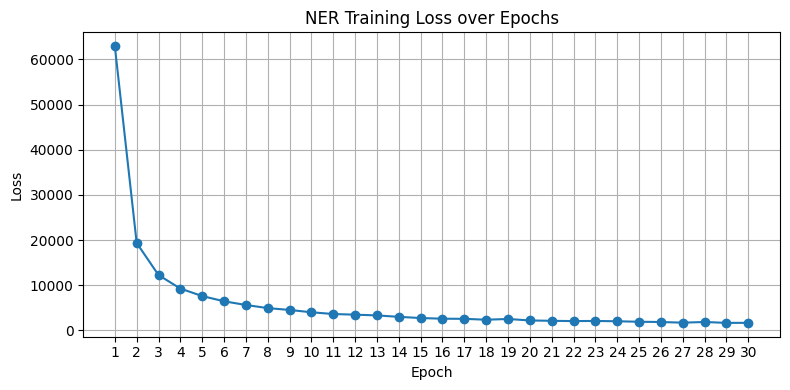

✅ Model saved to '4m_ner_model_v2_300d_30epochs'


In [116]:
import spacy
import random
import json
import matplotlib.pyplot as plt
from spacy.util import minibatch, load_model_from_config
from spacy.training.example import Example
from spacy.cli.init_config import init_config
from spacy.util import load_config_from_str
from tqdm.notebook import tqdm

# --- Configurable hyperparameters ---
embedding_dim = 300
epochs = 30
batch_size = 64

# --- Load training data ---
with open("01_Training/spacy_training_data_sentences.json", "r", encoding="utf-8") as f:
    training_data = json.load(f)
    nlp_temp = spacy.blank("de")
    examples = [Example.from_dict(nlp_temp.make_doc(text), ann) for text, ann in training_data]

# --- Build custom config string ---
config_str = f"""
[paths]
train = null
dev = null

[system]
seed = 42
gpu_allocator = "pytorch"

[nlp]
lang = "de"
pipeline = ["tok2vec", "ner"]
batch_size = {batch_size}

[components]

[components.tok2vec]
factory = "tok2vec"

[components.tok2vec.model]
@architectures = "spacy.Tok2Vec.v2"

[components.tok2vec.model.embed]
@architectures = "spacy.MultiHashEmbed.v2"
width = {embedding_dim}
rows = [5000, 2000, 1000, 1000]
attrs = ["ORTH", "SHAPE", "PREFIX", "SUFFIX"]
include_static_vectors = false

[components.tok2vec.model.encode]
@architectures = "spacy.MaxoutWindowEncoder.v2"
width = {embedding_dim}
window_size = 1
maxout_pieces = 3
depth = 2

[components.ner]
factory = "ner"

[initialize]
vectors = null
"""



# --- Load model from config ---
config = load_config_from_str(config_str)
nlp = load_model_from_config(config, auto_fill=True)

# --- Initialize labels from data ---
ner = nlp.get_pipe("ner")
for example in examples:
    for ent in example.reference.ents:
        ner.add_label(ent.label_)

# --- Initialize weights ---
nlp.initialize(lambda: examples)

# --- Training loop ---
loss_history = []
with nlp.select_pipes(enable=["ner", "tok2vec"]):
    optimizer = nlp.resume_training()
    for epoch in range(epochs):
        random.shuffle(examples)
        losses = {}
        batches = list(minibatch(examples, size=batch_size))
        for batch in tqdm(batches, desc=f"Epoch {epoch+1}", leave=False):
            nlp.update(batch, drop=0.3, losses=losses)
        print(f"Epoch {epoch+1} Loss: {losses}")
        loss_history.append(losses.get("ner", 0))

# --- Plot loss ---
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
plt.title("NER Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.xticks(range(1, len(loss_history) + 1))
plt.tight_layout()
plt.show()

# --- Save model ---
model_name = f"4m_ner_model_v2_{embedding_dim}d_{epochs}epochs"
nlp.to_disk(model_name)
print(f"✅ Model saved to '{model_name}'")


In [174]:
import psycopg2
import json
import spacy
from spacy import displacy

# --- Load DB config ---
config_file = r"C:\FHNW_lokal\6000\4M\01_ETL\21_load\db_config.json"

def load_config(config_path=config_file):
    with open(config_path) as f:
        return json.load(f)

# --- SQL: get one random text sample ---
query = """
SELECT dataset_title_DE, dataset_description_DE
FROM merged_dataset_metadata
WHERE dataset_description_DE IS NOT NULL
  AND dataset_title_DE IS NOT NULL
ORDER BY RANDOM()
LIMIT 1;
"""

# --- Fetch random row from database ---
config = load_config()

try:
    conn = psycopg2.connect(
        database="4M",
        user=config["user"],
        password=config["password"],
        host=config["host"],
        port=config["port"]
    )
    cur = conn.cursor()
    cur.execute(query)
    row = cur.fetchone()
    cur.close()
    conn.close()

    if row:
        title, description = row
        text = f"{title} {description}"
        print("📄 Text sample:\n", text)

        # --- Load models ---
        nlp_custom = spacy.load("4m_ner_model_v2_300d_30epochs")
        nlp_base = spacy.load("4m_ner_model_v1_10_epochs")

        # --- Process with both models ---
        doc_custom = nlp_custom(text)
        doc_base = nlp_base(text)

        # --- Print results ---
        print("\n🧠 Your Custom Model Predictions:")
        for ent in doc_custom.ents:
            if ent.label_ == "LOC":
                print(f" → {ent.text} [{ent.label_}]")

        print("\n🧠 spaCy de_core_news_lg Predictions:")
        for ent in doc_base.ents:
            if ent.label_ == "LOC":
                print(f" → {ent.text} [{ent.label_}]")

        # --- Visual comparison ---
        print("\n🔍 Your Model:")
        displacy.render(doc_custom, style="ent", jupyter=True)

        print("\n🔍 spaCy de_core_news_lg:")
        displacy.render(doc_base, style="ent", jupyter=True)

except Exception as e:
    print("❌ Error:", e)


📄 Text sample:
 Orthofoto 1990 Stadt Zürich - Sommer, Orthofoto_1990_Stadt_Zuerich___Sommer.tiff, Web Map Service, Web Map Tile Service Dieses historische Orthofoto wurde anhand analoger CIR-Luftbildern (Grün- Rot und IR-Kanal) von 1990 und dem Digitalen Geländemodell (DTM AV) inkl. Bruchkanten im Jahr 2015 erstellt. Das Farbbild (RGB) wurde anhand eines internen Prozesses berechnet. Die Auflösung (Raster) des Orthofotos ist 0.2cm.**Zweck**: Georeferenzdaten Stadt Zürich

🧠 Your Custom Model Predictions:
 → Stadt Zürich [LOC]
 → Stadt Zürich [LOC]

🧠 spaCy de_core_news_lg Predictions:
 → Stadt Zürich [LOC]
 → AV [LOC]
 → Stadt Zürich [LOC]

🔍 Your Model:



🔍 spaCy de_core_news_lg:


### New model with word vectors form existing model

In [80]:
import psycopg2
import json
import spacy
from spacy import displacy

# --- Load DB config ---
config_file = r"C:\FHNW_lokal\6000\4M\01_ETL\21_load\db_config.json"

def load_config(config_path=config_file):
    with open(config_path) as f:
        return json.load(f)

# --- SQL: get one random text sample ---
query = """
SELECT dataset_title_DE, dataset_description_DE
FROM merged_dataset_metadata
WHERE dataset_description_DE IS NOT NULL
  AND dataset_title_DE IS NOT NULL
ORDER BY RANDOM()
LIMIT 1;
"""

# --- Fetch random row from database ---
config = load_config()

try:
    conn = psycopg2.connect(
        database="4M",
        user=config["user"],
        password=config["password"],
        host=config["host"],
        port=config["port"]
    )
    cur = conn.cursor()
    cur.execute(query)
    row = cur.fetchone()
    cur.close()
    conn.close()

    if row:
        title, description = row
        text = f"{title} {description}"
        print("📄 Text sample:\n", text)

        # --- Load models ---
        nlp_custom = spacy.load("4m_ner_model_ft_300d_10epochs")
        nlp_base = spacy.load("4m_ner_model_v1_10_epochs")

        # --- Process with both models ---
        doc_custom = nlp_custom(text)
        doc_base = nlp_base(text)

        # --- Print results ---
        print("\n🧠 Your Custom Model Predictions:")
        for ent in doc_custom.ents:
            if ent.label_ == "LOC":
                print(f" → {ent.text} [{ent.label_}]")

        print("\n🧠 spaCy de_core_news_lg Predictions:")
        for ent in doc_base.ents:
            if ent.label_ == "LOC":
                print(f" → {ent.text} [{ent.label_}]")

        # --- Visual comparison ---
        print("\n🔍 Your Model:")
        displacy.render(doc_custom, style="ent", jupyter=True)

        print("\n🔍 spaCy de_core_news_lg:")
        displacy.render(doc_base, style="ent", jupyter=True)

except Exception as e:
    print("❌ Error:", e)


📄 Text sample:
 Risikokataster (Stationäre Risiken): Chemiebetriebe, ch_ag_geo_avs_risikobetrieb, AGIS Direktdownload Der Datensatz enthält Angaben zu Betrieben und Anlagen, die der Störfallverordnung (StFV) unterstehen. Neben den Betriebsadressen werden auch die zuständigen Chemie- und Stützpunktfeuerwehren, sowie die betroffenen Kläranlagen (ARAs) angegeben., Risikokataster (Stationäre Risiken): Chemiebetriebe, AGIS.avs_risikobetrieb

🧠 Your Custom Model Predictions:

🧠 spaCy de_core_news_lg Predictions:

🔍 Your Model:



🔍 spaCy de_core_news_lg:


In [11]:
import psycopg2
import json
import spacy
import re
from spacy import displacy

# --- Load DB config ---
config_file = r"C:\FHNW_lokal\6000\4M\01_ETL\21_load\db_config.json"

def load_config(config_path=config_file):
    with open(config_path) as f:
        return json.load(f)

# --- SQL: get one random text sample ---
query = """
SELECT dataset_title_DE, dataset_description_DE
FROM merged_dataset_metadata
WHERE dataset_title_DE IS NOT NULL
ORDER BY RANDOM()
LIMIT 1;
"""

# --- Choose mode ---
use_custom_text = False  # ← Set to False to use DB
enable_regex_lookup = True  # ← Enables third search method

# --- Load label list from JSON ---
if enable_regex_lookup:
    with open("03_Label/gemeinden_labels_categorized_v1.json", "r", encoding="utf-8") as f:
        categorized_labels = json.load(f)
    non_ambiguous_labels = [entry["label"] for entry in categorized_labels if not entry.get("ambiguous", True)]
    pattern = r'(?<!\w)(' + '|'.join(re.escape(label) for label in sorted(non_ambiguous_labels, key=len, reverse=True)) + r')(?!\w)'
    label_regex = re.compile(pattern)

# --- Fetch or define text ---
config = load_config()

try:
    conn = psycopg2.connect(
        database="4M",
        user=config["user"],
        password=config["password"],
        host=config["host"],
        port=config["port"]
    )
    cur = conn.cursor()
    cur.execute(query)
    row = cur.fetchone()
    cur.close()
    conn.close()

    if use_custom_text:
        text = """Die Gemeinde Zürich liegt im Kanton Zürich, nahe Bellikon und Wald.
        Ich wohne in Testikon und arbeite in Zürich. Auch Aefligen und Aefligens wurden besucht. (AG) ist ein Kanton."""
    else:
        title, description = row
        text = f"{title} {description}"

    print("📄 Text sample:\n", text)

    # --- Load models ---
    nlp_custom = spacy.load("02_Model/4m_ner_model_v1_10_epochs")
    nlp_base = spacy.load("de_core_news_lg")

    # --- Process with both models ---
    doc_custom = nlp_custom(text)
    doc_base = nlp_base(text)

    # --- Print results ---
    print("\n🧠 Your Custom Model Predictions:")
    for ent in doc_custom.ents:
        if ent.label_ == "LOC":
            print(f" → {ent.text} [{ent.label_}]")

    print("\n🧠 Baseline Model Predictions:")
    for ent in doc_base.ents:
        if ent.label_ == "LOC":
            print(f" → {ent.text} [{ent.label_}]")


    if enable_regex_lookup:
        print("\n🔎 Regex Matches from Label List:")
        # Use blank pipeline to create a doc
        doc_regex = spacy.blank("de")(text)

        spans = []
        for match in label_regex.finditer(text):
            print(f" → {match.group()} [pos {match.start()}–{match.end()}]")
            span = doc_regex.char_span(match.start(), match.end(), label="LOC")
            if span:
                spans.append(span)

    doc_regex.ents = spans

    print("\n🔍 Regex Label Matches:")
    displacy.render(doc_regex, style="ent", jupyter=True)

    # --- Visual comparison ---
    print("\n🔍 Your Model:")
    displacy.render(doc_custom, style="ent", jupyter=True)

    print("\n🔍 Baseline Model:")
    displacy.render(doc_base, style="ent", jupyter=True)

except Exception as e:
    print("❌ Error:", e)


📄 Text sample:
 Daten der amtlichen Vermessung (Gemeinde Pfeffingen) Qualitätsstandard: Ganze Gemeinde AV93 - Alle Datenebenen der amtlichen Vermessung 93 sind erfasst und weisen die vorgeschriebene Qualität und Zuverlässigkeit gemäss kantonalen und eidgenössischen Vorschriften aus. Detailliertere Angaben erteilt der zuständige Nachführungsgeometer. Für allgemeine Informationen zu den Daten der amtlichen Vermessung des Kantons BL konsultieren Sie bitte den Geometadatensatz "Daten der amtlichen Vermessung (Kanton BL)".

🧠 Your Custom Model Predictions:
 → Pfeffingen [LOC]
 → Kantons BL [LOC]
 → Kanton BL [LOC]

🧠 Baseline Model Predictions:
 → Pfeffingen [LOC]
 → AV93 [LOC]
 → BL [LOC]
 → Kanton BL [LOC]

🔎 Regex Matches from Label List:
 → Pfeffingen [pos 41–51]
 → BL [pos 415–417]
 → BL [pos 502–504]

🔍 Regex Label Matches:



🔍 Your Model:



🔍 Baseline Model:
